#IC-SHM Component Recognition Model
Run the following cells till the first checkpoint for training

In [ ]:
#Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import tensorflow as tf
print("tensorflow version:",tf.__version__)

import numpy as np
print("numpy version:",np.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:",matplotlib.__version__)

import pandas as pd
print("pandas version:",pd.__version__)

from skimage.transform import resize

from tensorflow.keras import datasets, layers, models

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#Monting G-Drive to access the datasets
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [ ]:
#Function to change the path format 
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [ ]:
# Function to put the label images into 7 channels

def get_label(file_path):

    mask = np.squeeze(file_path, axis = 2)

    target_array = np.zeros((mask.shape[0],mask.shape[1],7))
    target_array[:,:,0]=np.where(mask == 1, 1, 0)
    target_array[:,:,1]=np.where(mask == 2, 1, 0)
    target_array[:,:,2]=np.where(mask == 3, 1, 0)
    target_array[:,:,3]=np.where(mask == 4, 1, 0)
    target_array[:,:,4]=np.where(mask == 5, 1, 0)
    target_array[:,:,5]=np.where(mask == 6, 1, 0)
    target_array[:,:,6]=np.where(mask == 7, 1, 0)

    return target_array

In [ ]:
# Function to normalize the images
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [ ]:
# Functions to plot the images and labels
def show_img(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

def show_label(label):
  fig, axes = plt.subplots(1, 7, figsize=(16, 112))
  y = label.numpy()
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[3].axis('off')
  axes[4].axis('off')
  axes[5].axis('off')
  axes[6].axis('off')
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  y4 = y[:,:,3]
  y5 = y[:,:,4]
  y6 = y[:,:,5]
  y7 = y[:,:,6]
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)
  axes[3].imshow(y4)
  axes[4].imshow(y5)
  axes[5].imshow(y6)
  axes[6].imshow(y7)

In [ ]:
# Function to print the prediction images
def show_pred(y):
  fig, axes = plt.subplots(1, 7, figsize=(16, 112))
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  y4 = y[:,:,3]
  y5 = y[:,:,4]
  y6 = y[:,:,5]
  y7 = y[:,:,6]
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[3].axis('off')
  axes[4].axis('off')
  axes[5].axis('off')
  axes[6].axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)
  axes[3].imshow(y4)
  axes[4].imshow(y5)
  axes[5].imshow(y6)
  axes[6].imshow(y7)

###Checkpoint - 1
Run untill here for training and testing alike.

In [ ]:
# Image and Label augmentation function 
# Uncomment the second line when cropping needed

def image_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  #img = tf.image.stateless_random_crop(value = img, size = (192, 320, 3), seed = seed, name=None) 
  return img

def label_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  #img = tf.image.stateless_random_crop(value = img, size = (192, 320, 7), seed = seed, name=None) 
  return img

In [ ]:
# Tensorflow data pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)        #Prefetching the data form improved speed 
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess, num_parallel_calls= tf.data.AUTOTUNE)     
    dataset = dataset.batch(batch, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset

In [ ]:
# Preprocess function to run all the required preprocessing functions on the images
def preprocess(x, y):
    def f(x, y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 0)
        x = tf.image.resize(x, [360,640])
        x = tf.numpy_function(normalize, [x], [tf.float32])
        y = tf.io.decode_bmp(y, channels = 0)
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize(y, [360,640])
        x = tf.image.resize_with_pad(x, 192, 320)       #Comment this line out when cropping in augmentation
        y = tf.image.resize_with_pad(y, 192, 320)       #Comment this line out when cropping in augmentation
        x = tf.numpy_function(image_augmentation, [x], [tf.float32])
        y = tf.numpy_function(label_augmentation, [y], [tf.float32])
        
        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([192, 320, 3])
    masks.set_shape([192, 320, 7])

    return images, masks

In [ ]:
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('/content/drive/MyDrive/IC-SHM 2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]

In [ ]:
#training and validation split
train1 = train_comp[:7000]
val1 = train_comp[7000:]

In [ ]:
# Creating the tf dataset from dataframe containing image addresses
images = train1['image file name'].to_numpy()
masks = train1['component label file name'].to_numpy()
dataset = tf_dataset(images, masks)
images_val = val1['image file name'].to_numpy( )
masks_val = val1['component label file name'].to_numpy()
dataset_val = tf_dataset(images_val, masks_val)

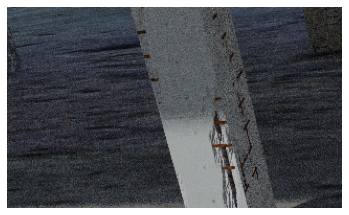

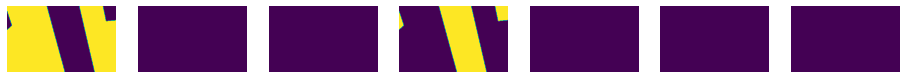

In [ ]:
#Printing out an image for reference
for x, y in dataset.take(1):
        show_img(x[0])
        show_label(y[0])
        break

###Checkpoint - 2

In [ ]:
#Importing the necessary Keras libraries for Creating a Model
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Add, ZeroPadding2D
from keras.models import Model

In [ ]:
# Custom Conv blocks for the unet 2
def conv_1(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def conv_2(input, num_filters):
  x = Conv2D(num_filters, 5, padding="same", dilation_rate = 2)(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same", dilation_rate = 3)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

#Additional conv layers for 

def conv_3(input, num_filters):

  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 5, padding="same", dilation_rate = 2)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same", dilation_rate = 2)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def conv_starter(input, num_filters):
  x2 = Conv2D(num_filters, 5, padding="same")(input)
  x2 = BatchNormalization()(x2)
  x3 = Conv2D(num_filters, 3, padding="same", dilation_rate = 2)(input)
  x3 = BatchNormalization()(x3)
  x5 = Conv2D(num_filters, 3, padding="same")(input)
  x5 = BatchNormalization()(x5)
  x = Add()([x2, x3, x5])
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def conv_block1(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Custom Encoder blocks for Unet2
def encoder_1(input, num_filters):
  x = conv_1(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def encoder_2(input, num_filters):
  x = conv_2(input, num_filters)
  x = conv_3(x, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

# Decoder blocks for unet2
def decoder_block1(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block1(x, num_filters)
    return x

def decoder_block2(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="valid")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block1(x, num_filters)
    return x

def build_unet(input_shape):
  inputs = Input(input_shape)

  s = conv_starter(inputs, 64)

  s1, p1 = encoder_2(s, 64)
  s2, p2 = encoder_1(p1, 128)

  b1 = conv_3(p2, 256)
  b2 = conv_2(b1, 512)
  b3 = conv_2(b2, 1024)
  b4 = conv_1(b3, 512)
  b5 = conv_1(b4, 256)

  d4 = decoder_block1(b5, s2, 128)
  d5 = decoder_block1(d4, s1, 64)

  outputs = Conv2D(7, 1, padding="same", activation="sigmoid")(d5)

  model = Model(inputs, outputs, name="U-Net")
  return model

In [ ]:
input_shape = (192, 320, 3)
model = build_unet(input_shape)
model.summary()




###Checkpoint 3

In [ ]:
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [ ]:
checkpoint_path = os.path.join(path_ds, "training_2_cmp2/cp_cmp_2layer.ckpt") #Change the checkpoint path  
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
""" Courtesy stackoverflow Daniel Möller https://stackoverflow.com/users/2097240/daniel-m%c3%b6ller?tab=profile
answer to question "Custom loss function for U-net in keras using class weights: `class_weight` not supported for 3+ dimensional targets""""
# Weighted loss function  
from keras import backend as K
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [ ]:
# The weights for each class are hardcoded here and are calculated using the code presented towards the end of this notebook
weights=[(12.271834261551124/53.876072549963204),(12.271834261551124/12.765564322057187),(12.271834261551124/12.271834261551124),(12.271834261551124/17.37891736569488),(12.271834261551124/2.8669312087458843),(12.271834261551124/0.6609945109094115),(12.271834261551124/0.1793254950495065)]

In [ ]:
#Compiling the model
model.compile(optimizer= optimizer_adam,
              loss= weightedLoss(tf.keras.losses.BinaryCrossentropy(), weights),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(thresholds = 0.4), #Threshold value is changed from 0.5 to for higher probabilistic predictions
                       tf.keras.metrics.Precision(thresholds = 0.7),
                       tf.keras.metrics.MeanIoU(7)])

In [ ]:
#Loading checkpoint weights
model.load_weights(checkpoint_path)

###Checkpoint 4

In [ ]:
#Train the model
history = model.fit(dataset, epochs=30 ,validation_data= dataset_val, verbose = 1, callbacks = cp_callback, use_multiprocessing = True)

In [ ]:
#Print Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
#Print Binary Accuracy
accu = history.history['binary_accuracy']
val_accu = history.history['val_binary_accuracy']

plt.figure()
plt.plot(history.epoch, accu, 'r', label='Training binary accuracy')
plt.plot(history.epoch, val_accu, 'b', label='Validation binary accuracy')
plt.title('Training and Validation binary accuracy')
plt.xlabel('Epoch')
plt.ylabel('binary accuracy Value')
plt.legend()
plt.show()

In [ ]:
#print recall
recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure()
plt.plot(history.epoch, recall, 'r', label='Training recall')
plt.plot(history.epoch, val_recall, 'b', label='Validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epoch')
plt.ylabel('recall Value')
plt.legend()
plt.show()

In [ ]:
#Print precision
pres = history.history['precision']
val_pres = history.history['val_precision']

plt.figure()
plt.plot(history.epoch, pres, 'r', label='Training precision')
plt.plot(history.epoch, val_pres, 'b', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision Value')
plt.legend()
plt.show()

In [ ]:
#Print Mean IoU
miou = history.history['mean_io_u']
val_miou = history.history['val_mean_io_u']

plt.figure()
plt.plot(history.epoch, miou, 'r', label='Training mean_io_u')
plt.plot(history.epoch, val_miou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u Value')
plt.legend()
plt.show()

In [ ]:
#Evaluate the model on validation dataset
model.evaluate(dataset_val, verbose = 1)

In [ ]:
#Printing predictions on the validation dataset
z=1
for x, y in dataset_val.take(10):
        z += 1
        show_img(x[1])
        show_label(y[1])
        pred = model.predict(x)
        show_pred(pred[1])
        if (z==9):
          break

###Checkpoint 5

In [ ]:
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('/content/drive/MyDrive/IC-SHM 2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftest = pd.read_csv(os.path.join(path_ds,'files_test.csv'),names = col_names,delimiter=',')
ftest.iloc[:,0] = ftest.iloc[:,0].apply(lambda x: path_correct(x))
ftest.iloc[:,1] = ftest.iloc[:,1].apply(lambda x: path_correct(x))
ftest.iloc[:,2] = ftest.iloc[:,2].apply(lambda x: path_correct(x))
ftest.iloc[:,3] = ftest.iloc[:,3].apply(lambda x: path_correct(x))
test_comp = ftest.loc[ftest['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]

In [ ]:
#Preprocessing for the test dataset
def preprocess_test(x,y):
    def f(x,y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 0)
        x = tf.image.resize_with_pad(x, 192,320)
        x = tf.numpy_function(normalize, [x], [tf.float32]) 
        y = tf.io.decode_bmp(y, channels = 0)   
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize_with_pad(y, 192, 320)   

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([192, 320, 3])
    masks.set_shape([192, 320, 7])

    return images, masks

In [ ]:
def tf_dataset_test(x,y, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_test, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.batch(batch, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset

In [ ]:
images_test = test_comp['image file name'].to_numpy()
masks_test = test_comp['component label file name'].to_numpy()
dataset_test = tf_dataset_test(images_test, masks_test)
address = test_comp['component label file name'].apply(lambda x : os.path.split(x)[1]).to_numpy()

In [ ]:
#Printing the predictions for the test dataset
z=1
for x, y in dataset_test.take(10):
        z += 1
        show_img(x[0])
        show_label(y[2])
        pred = model.predict(x)
        show_pred(pred[0])
        if (z==9):
          break

###Checkpoint 6

In [ ]:
#Function to create the predictions and upscale them to size (360, 640) and then save in the drive folder
from PIL import Image
import imageio
import cv2

root_path = '/content/drive/MyDrive/IC-SHM 2021/Tokaido_dataset/Prediction_lab1' #Change the root folder as per the system

def size_changer(img):
  mask = np.zeros((360,640, img.shape[2]), dtype = np.uint8)
  for i in range(img.shape[2]):
    temp = np.where(img[:,:,i] > 0.6, 1, 0)
    temp = cv2.resize(temp.astype('uint8'), dsize = (640,360), interpolation=cv2.INTER_CUBIC)
    temp = np.where(temp > 0.6, 1, 0)
    mask[:,:,i] = temp
  return mask

def crop(img):
  image = img[6:186,:,:]
  return image

def mask_save(img, save_path):
  path = os.path.join(root_path, 'synthetic/test/labcmp') #Change this path as per system
  img = crop(img)
  img = size_changer(img)
  mask = img
  output = np.zeros((mask.shape[0],mask.shape[1]), dtype = np.uint8)
  output = np.argmax(mask, axis = 2)
  output = output + 1

  imageio.imwrite(os.path.join(path, save_path), output.astype('uint8'))

  return None

i = 0
for item in dataset_test:
  p = model.predict(item[0])
  for j in range(len(p)):
    mask_save(p[j], os.path.join(address[i]))
    i += 1
    print(i)